In [88]:
# ===========================
# 🔧 Core Libraries
# ===========================
import pandas as pd
import numpy as np

# ===========================
# 📊 Visualization
# ===========================
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

# ===========================
# 🧪 Model Preparation
# ===========================
from sklearn.model_selection import train_test_split, cross_val_score
from imblearn.over_sampling import SMOTE

# ===========================
# 🤖 Classification Models
# ===========================
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier

# ===========================
# 📈 Evaluation Metrics
# ===========================
from sklearn.metrics import classification_report, confusion_matrix

## Load the Dataset & Inspect Structure

In [89]:
df2 = pd.read_csv(r"C:\Users\Admin\Documents\GitHub\StudentLifestyle-StressLevel-Classification\student_lifestyle_dataset.csv")

df2.head()

,Student_ID,Study_Hours_Per_Day,Extracurricular_Hours_Per_Day,Sleep_Hours_Per_Day,Social_Hours_Per_Day,Physical_Activity_Hours_Per_Day,GPA,Stress_Level
0,1,6.9,3.8,8.7,2.8,1.8,2.99,Moderate
1,2,5.3,3.5,8.0,4.2,3.0,2.75,Low
2,3,5.1,3.9,9.2,1.2,4.6,2.67,Low
3,4,6.5,2.1,7.2,1.7,6.5,2.88,Moderate
4,5,8.1,0.6,6.5,2.2,6.6,3.51,High


- This dataset contains data from 2,000 students collected via a Google Form survey. It includes information on study hours, extracurricular activities, sleep, socializing, physical activity, stress levels, and CGPA. The data covers an academic year from August 2023 to May 2024 and reflects student lifestyles primarily from India.

In [90]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 8 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Student_ID                       2000 non-null   int64  
 1   Study_Hours_Per_Day              2000 non-null   float64
 2   Extracurricular_Hours_Per_Day    2000 non-null   float64
 3   Sleep_Hours_Per_Day              2000 non-null   float64
 4   Social_Hours_Per_Day             2000 non-null   float64
 5   Physical_Activity_Hours_Per_Day  2000 non-null   float64
 6   GPA                              2000 non-null   float64
 7   Stress_Level                     2000 non-null   object 
dtypes: float64(6), int64(1), object(1)
memory usage: 125.1+ KB


In [91]:
### Quick Checks

In [92]:
df2['Stress_Level'].value_counts()

Stress_Level
High        1029
Moderate     674
Low          297
Name: count, dtype: int64

In [93]:
# Drop 'Student_ID' column
df2 = df2.drop('Student_ID', axis=1)

## SECTION 2: Outlier Detection

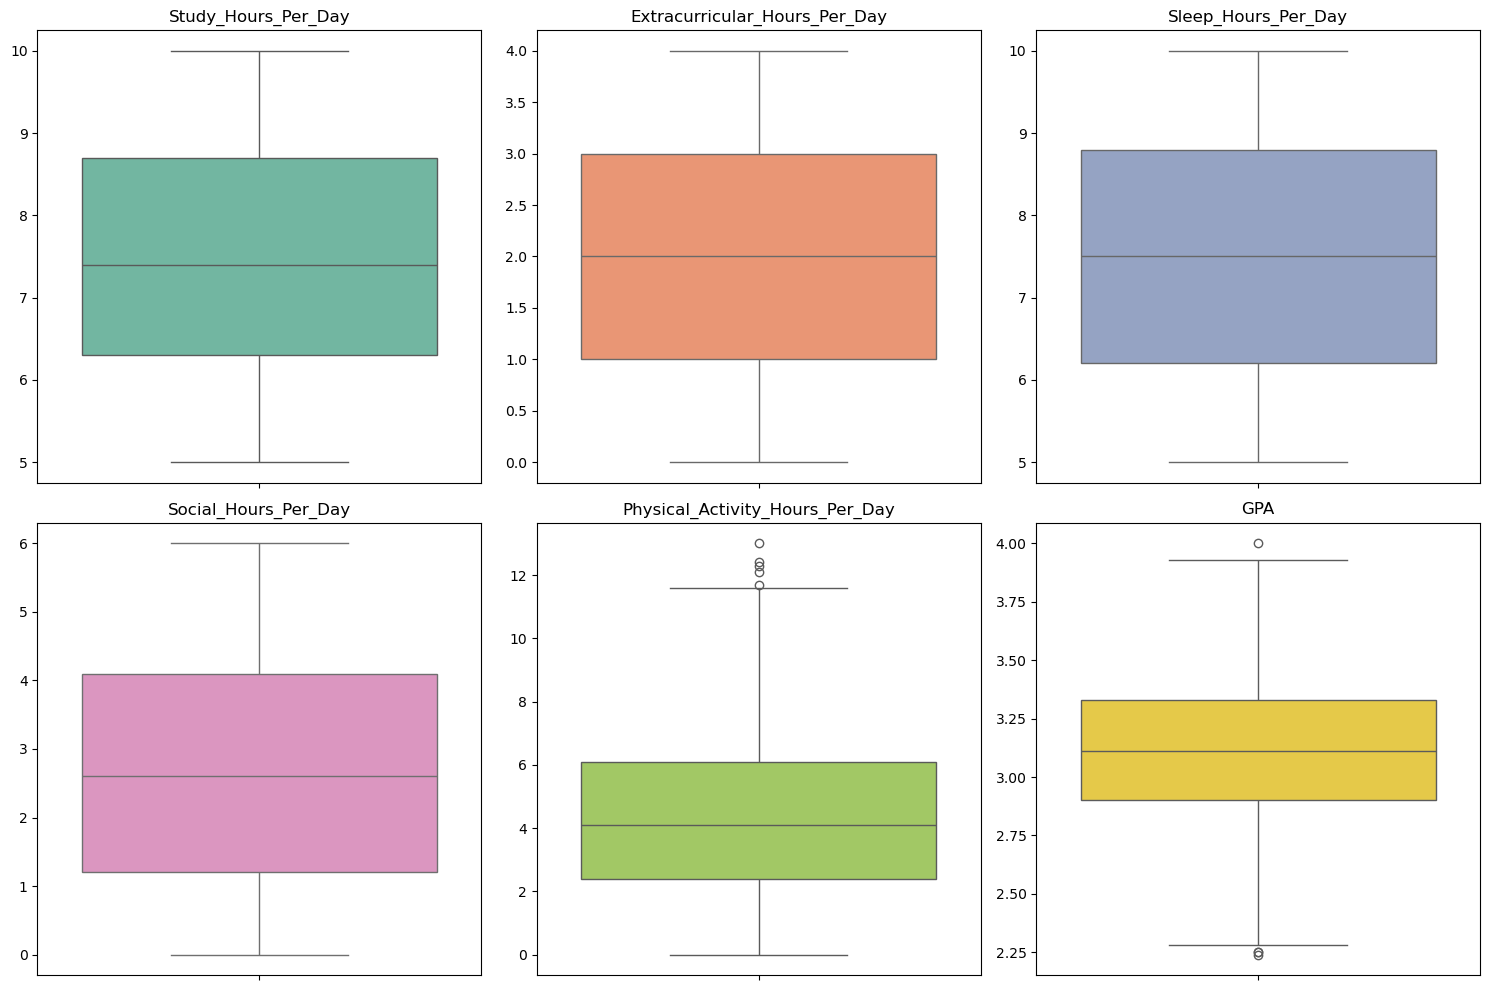

In [94]:
import math
num_cols = df2.drop("Stress_Level", axis=1).columns
colors = sns.color_palette("Set2", len(num_cols))  # unique colors for each column

# Set number of columns per row
cols_per_row = 3
rows = math.ceil(len(num_cols) / cols_per_row)

fig, axes = plt.subplots(nrows=rows, ncols=cols_per_row, figsize=(5*cols_per_row, 5*rows))

# Flatten axes array for easy indexing (if only one row, axes might not be 2D)
axes = axes.flatten()

for i, col in enumerate(num_cols):
    sns.boxplot(y=df2[col], ax=axes[i], color=colors[i])
    axes[i].set_title(col)
    axes[i].set_ylabel("")

# Remove any empty subplots
for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

The boxplot shows that most numerical features fall within reasonable ranges, with only one feature needing correction:

**Study Hours, Sleep Hours, Social Hours, Extracurricular Hours, GPA**

→ These features show natural variation.

→ Outliers observed (like 0 hours of social/extracurricular activities) are realistic behaviors, not errors.

→ No removal or correction needed.

**Physical Activity Hours Per Day**

→ This feature contains clear extreme outliers (values 11-13 hours/day).

→ Such high activity levels are unrealistic for students and likely due to data-entry mistakes.

→ Recommended: cap values at a maximum of 8 hours to prevent distortion during modeling.

### Alternative Interactive Graphs

In [95]:
# All numeric columns except the target
num_cols = df2.drop("Stress_Level", axis=1).columns

for col in num_cols:
    fig = px.box(df2, y=col, title=f"Boxplot of {col}")
    fig.show()

#### Handling Outlier

In [96]:
df2['Physical_Activity_Hours_Per_Day'] = df2['Physical_Activity_Hours_Per_Day'].clip(0, 8)

- A few students reported extremely high physical activity hours (11-13 hours per day), which is unrealistic and likely due to survey exaggeration or data-entry errors. Using the above code we cap all values above 8 hours to 8, keeping the data within a realistic human range.
Clipping avoids removing rows (which preserves dataset size) while reducing the influence of extreme outliers on the model.

## SECTION 3: Exploratory Data Analysis

### Univariate Analysis

In [97]:
df2.describe().T

,count,mean,std,min,25%,50%,75%,max
Study_Hours_Per_Day,2000.0,7.47580,1.423888,5.00,6.3,7.40,8.70,10.0
Extracurricular_Hours_Per_Day,2000.0,1.99010,1.155855,0.00,1.0,2.00,3.00,4.0
Sleep_Hours_Per_Day,2000.0,7.50125,1.460949,5.00,6.2,7.50,8.80,10.0
Social_Hours_Per_Day,2000.0,2.70455,1.688514,0.00,1.2,2.60,4.10,6.0
Physical_Activity_Hours_Per_Day,2000.0,4.22215,2.306680,0.00,2.4,4.10,6.10,8.0
GPA,2000.0,3.11596,0.298674,2.24,2.9,3.11,3.33,4.0


**📊 Summary Statistics Interpretation (df.describe())**

The table above summarizes the distribution of all numerical features in the dataset.
Here are the key insights derived from it:

⭐ 1. Study & Extracurricular Hours

- Students study 7.47 hours/day on average, with a range from 5 to 10 hours.
- Extracurricular activities range from 0 to 4 hours, with an average of ~2 hours/day.

This suggests that the dataset includes both highly active students and those with zero extracurricular involvement.

⭐ 2. Sleep Hours

- Average sleep: 7.50 hours/day
- Range: 5 to 10 hours

This is a healthy distribution and may strongly influence stress levels.

⭐ 3. Social Hours

- Mean: 2.70 hours/day
- Range: 0 to 6 hours

This shows high lifestyle variability - some students socialize a lot while others not at all.

⭐ 4. Physical Activity

- Average: 4.33 hours/day
- Range: 0 to 13 hours

13 hours is unusually high → may be an outlier (we will handle this in outlier detection).

⭐ 5. GPA

- Average GPA: 3.11
- Range: 2.24 to 4.0

This indicates mostly good academic performance across the sample.

⭐ 6. Stress Level (Encoded Target)

Encoded as:
- 0 = Low
- 1 = Moderate
- 2 = High

Mean = 1.366, confirming that High stress is the most frequent class.

📌 Conclusion

These statistics show that:

- Students have diverse lifestyles.
- Stress levels are likely influenced by study habits, sleep, physical activity, and social time.
- There are potential outliers (especially in Physical Activity hours).
- Class imbalance must be handled.

### Graph Representation of the Univariate Analysis

#### Interactive Graph

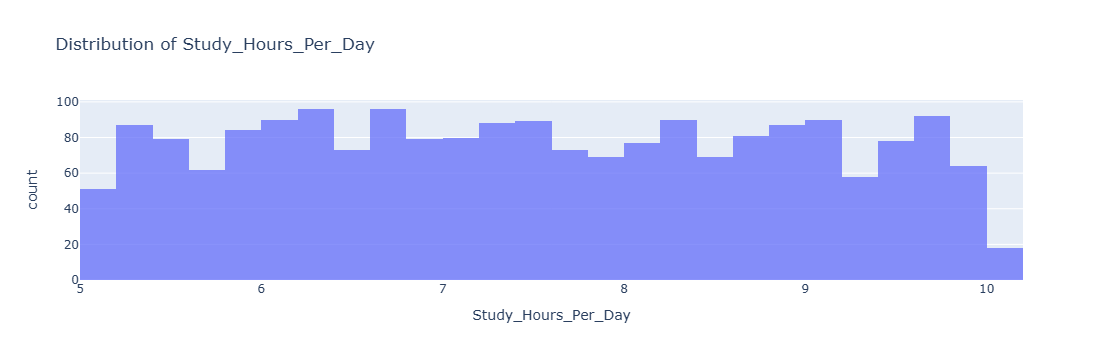

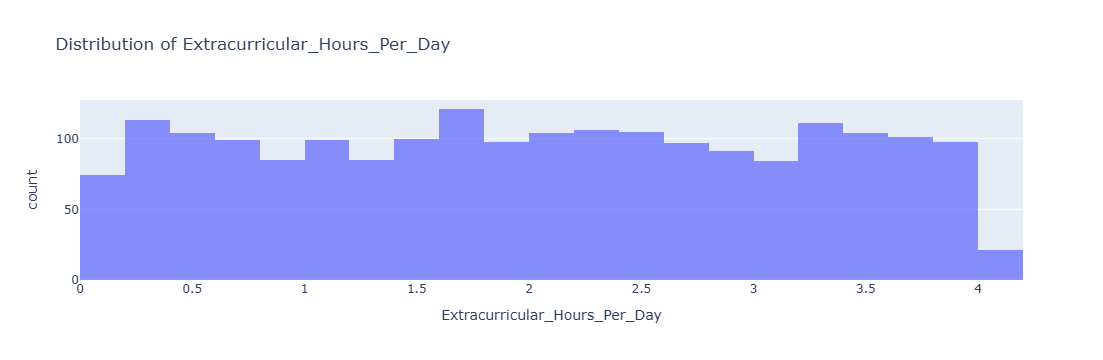

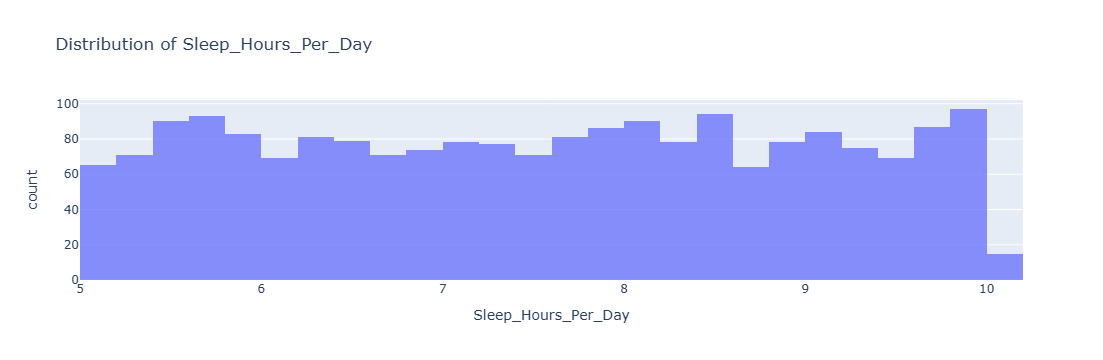

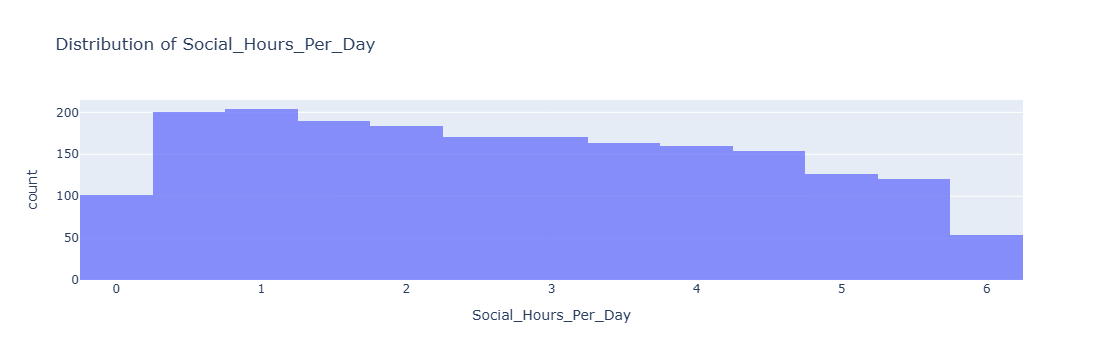

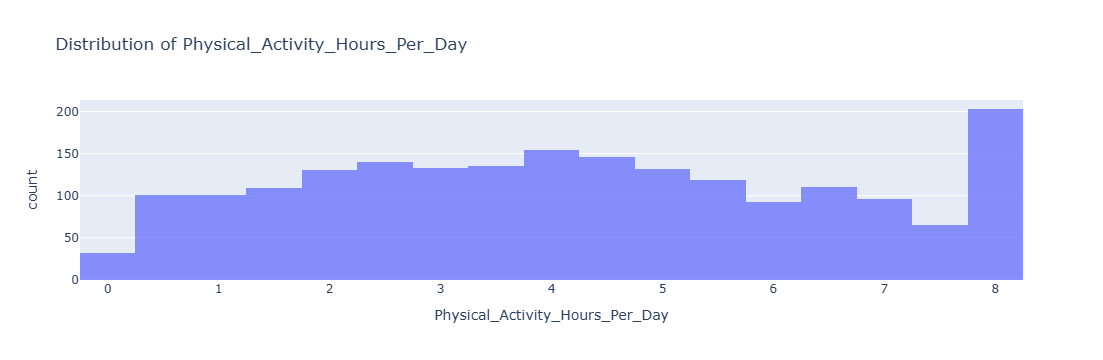

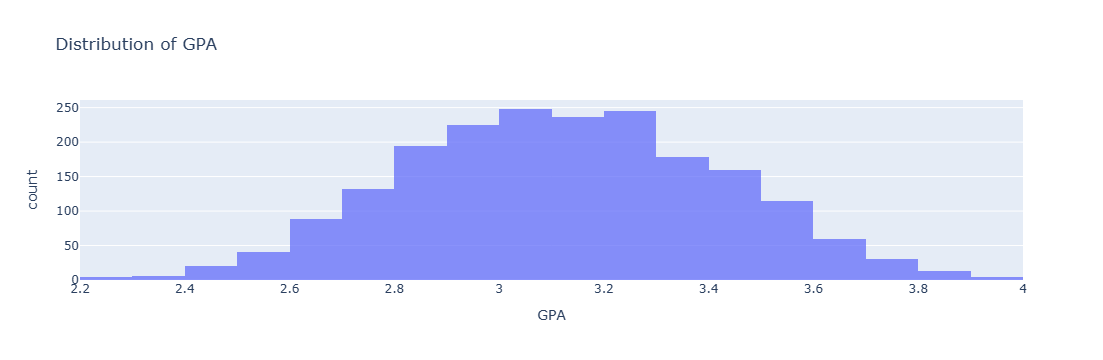

In [98]:
# All numeric columns except the target
num_cols = df2.drop("Stress_Level", axis=1).columns

for col in num_cols:
    fig = px.histogram(
        df2, 
        x=col,
        nbins=30,
        title=f"Distribution of {col}",
        opacity=0.75
    )
    fig.show()


#### Stable Graphs

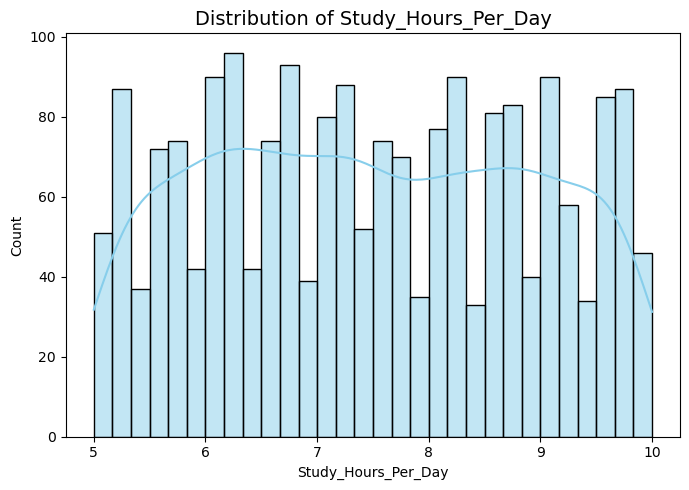

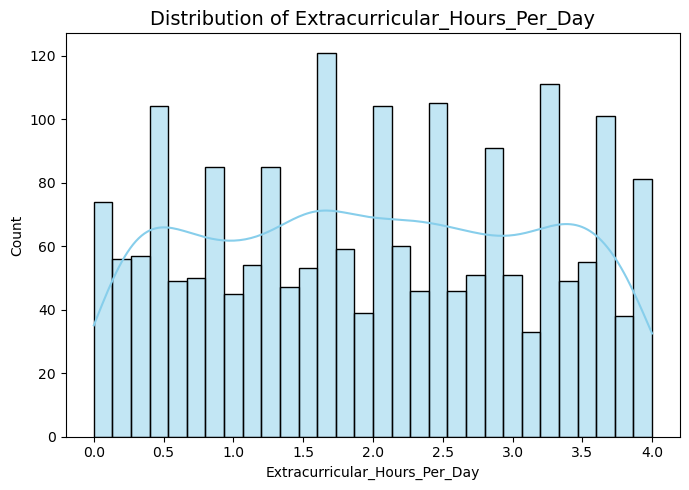

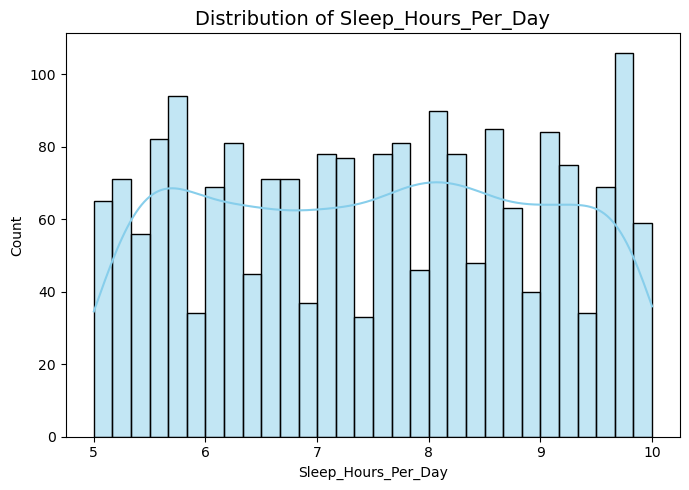

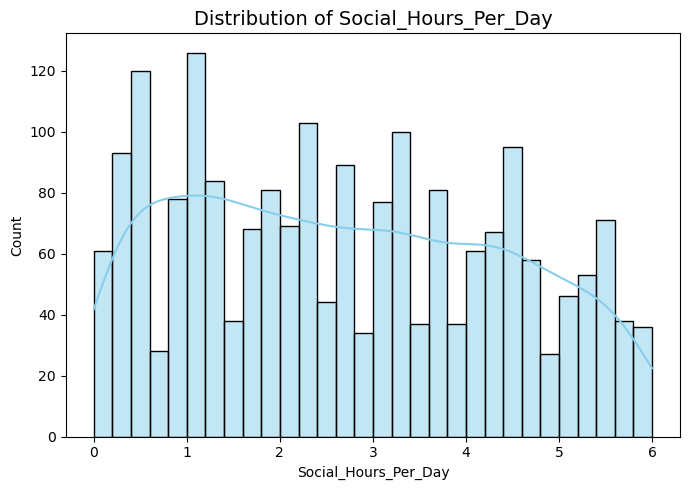

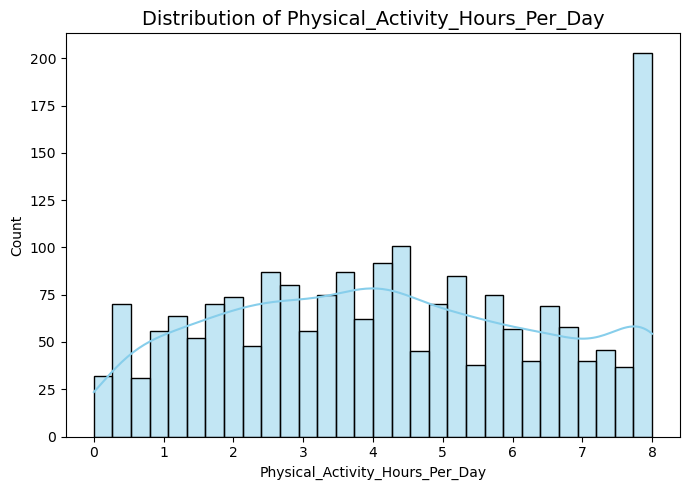

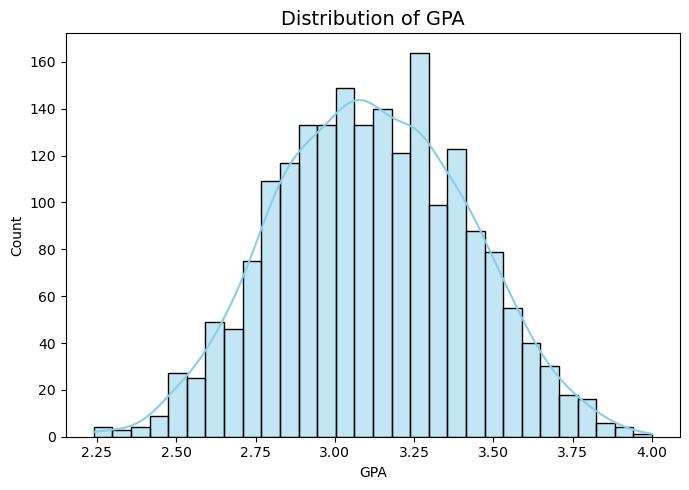

In [99]:
# All numeric columns except the target
num_cols = df2.drop("Stress_Level", axis=1).columns

for col in num_cols:
    plt.figure(figsize=(7, 5))
    sns.histplot(df2[col], bins=30, kde=True, color='skyblue', edgecolor='black')
    plt.title(f"Distribution of {col}", fontsize=14)
    plt.xlabel(col)
    plt.ylabel("Count")
    plt.tight_layout()
    plt.savefig(f"hist_{col}.png", dpi=300)  # optional: save plot
    plt.show()


### Bivariate Analysis

#### Distribution of Features by The Target Varaible (Stress Level)

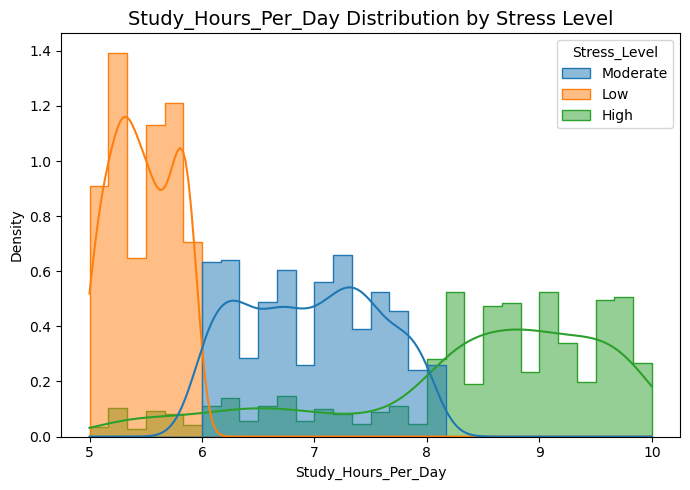

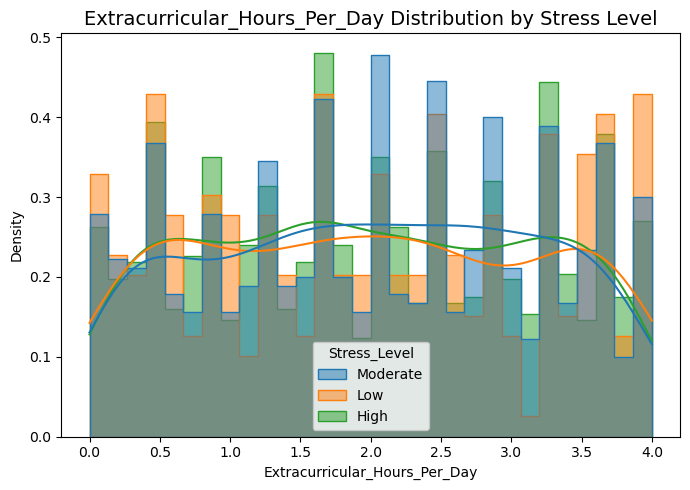

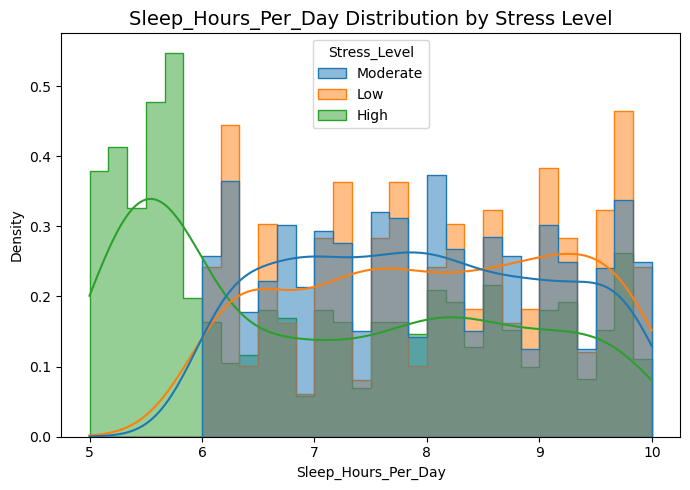

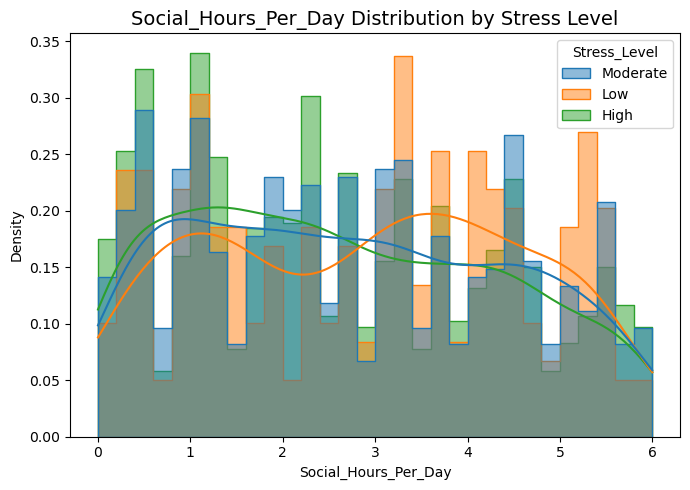

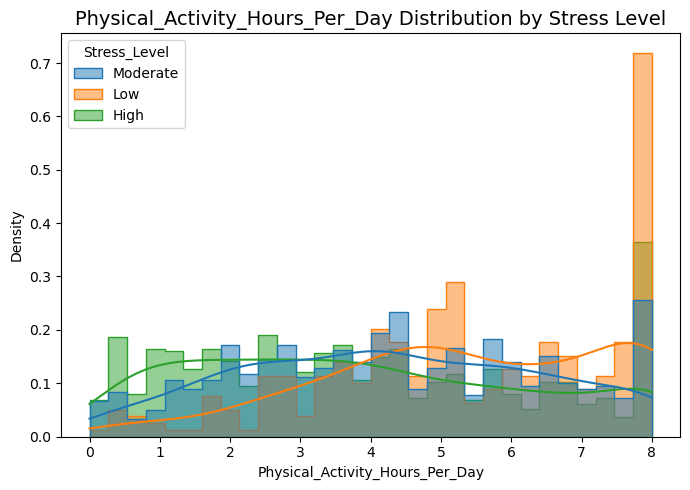

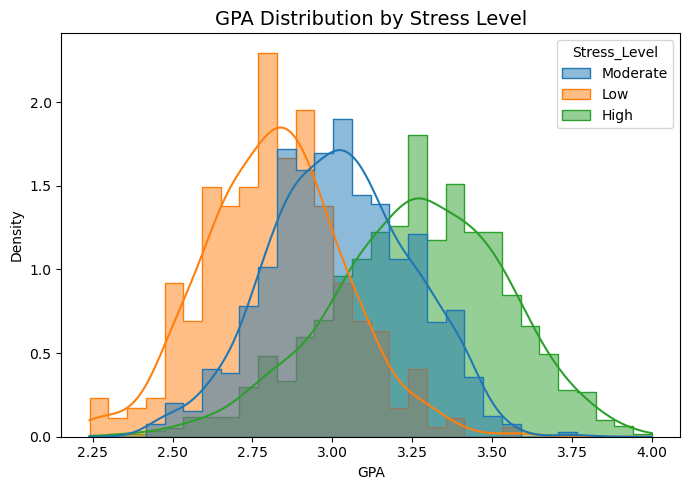

In [128]:
# numeric columns except target
num_cols = df2.select_dtypes(include=['float64', 'int64']).columns
num_cols = [col for col in num_cols if col != "Stress_Level"]

for col in num_cols:
    plt.figure(figsize=(7, 5))

    sns.histplot(
        data=df2,
        x=col,
        hue="Stress_Level",     # <--- use this
        bins=30,
        element='step',
        stat='density',
        kde=True,
        common_norm=False,
        alpha=0.5
    )

    plt.title(f"{col} Distribution by Stress Level", fontsize=14)
    plt.xlabel(col)
    plt.tight_layout()
    plt.show()


In [134]:
df2.groupby("Stress_Level").mean().round(3)

,Study_Hours_Per_Day,Extracurricular_Hours_Per_Day,Sleep_Hours_Per_Day,Social_Hours_Per_Day,Physical_Activity_Hours_Per_Day,GPA
Stress_Level,,,,,,
High,8.385,1.980,7.046,2.628,3.845,3.262
Low,5.474,1.989,8.064,2.891,5.386,2.817
Moderate,6.970,2.006,7.948,2.740,4.285,3.025


**📌 Interpretation of Mean Features Across Stress Levels**

The table shows clear behavioral differences between high-, moderate-, and low-stress students:

- **High-stress students study the most (8.39 hrs) and sleep the least (7.05 hrs)**, showing a strong academic pressure pattern.

- **Low-stress students sleep more (8.06 hrs) and exercise more (5.39 hrs)**, supporting the idea that balanced lifestyle habits reduce stress.

- **High-stress students have the highest GPA**, suggesting academic excellence may come with increased workload and pressure.

- **Social hours and extracurricular hours show minimal differences**, meaning they are less influential for stress classification.

Overall, study hours, sleep duration, and physical activity appear to be **the strongest behavioral indicators of stress level.**

### Class Distribution

In [102]:
df2['Stress_Level'].value_counts().sort_index()

Stress_Level
High        1029
Low          297
Moderate     674
Name: count, dtype: int64

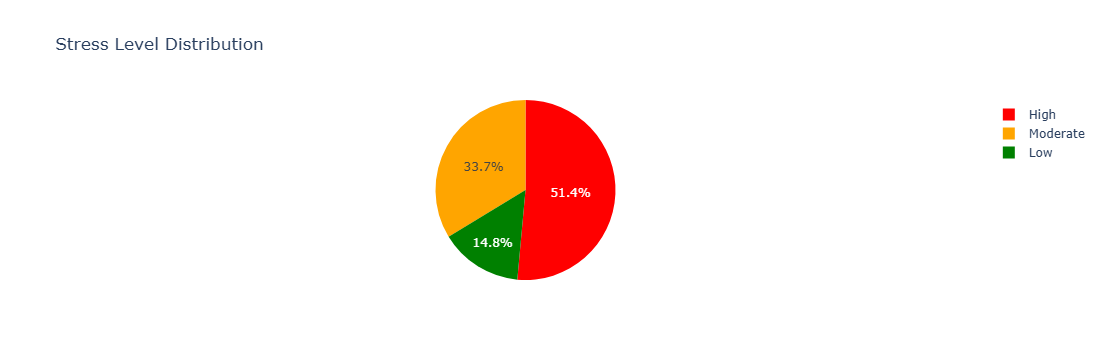

In [103]:
# Prepare data
df_counts = df2['Stress_Level'].value_counts().reset_index()
df_counts.columns = ['Stress_Level', 'Count']

# PIE CHART
fig = px.pie(
    df_counts,
    names='Stress_Level',
    values='Count',
    title='Stress Level Distribution',
    color='Stress_Level',
    color_discrete_map={
        'Low': 'green',
        'Moderate': 'orange',
        'High': 'red'
    }
)

fig.show()

Target Distribution, the dataset is imbalanced:

- High stress: 1029 students

- Moderate stress: 674 students

- Low stress: 297 students

This imbalance will affect classification performance, so we will handle it later using class weights or SMOTE.

### Multivariate Analysis

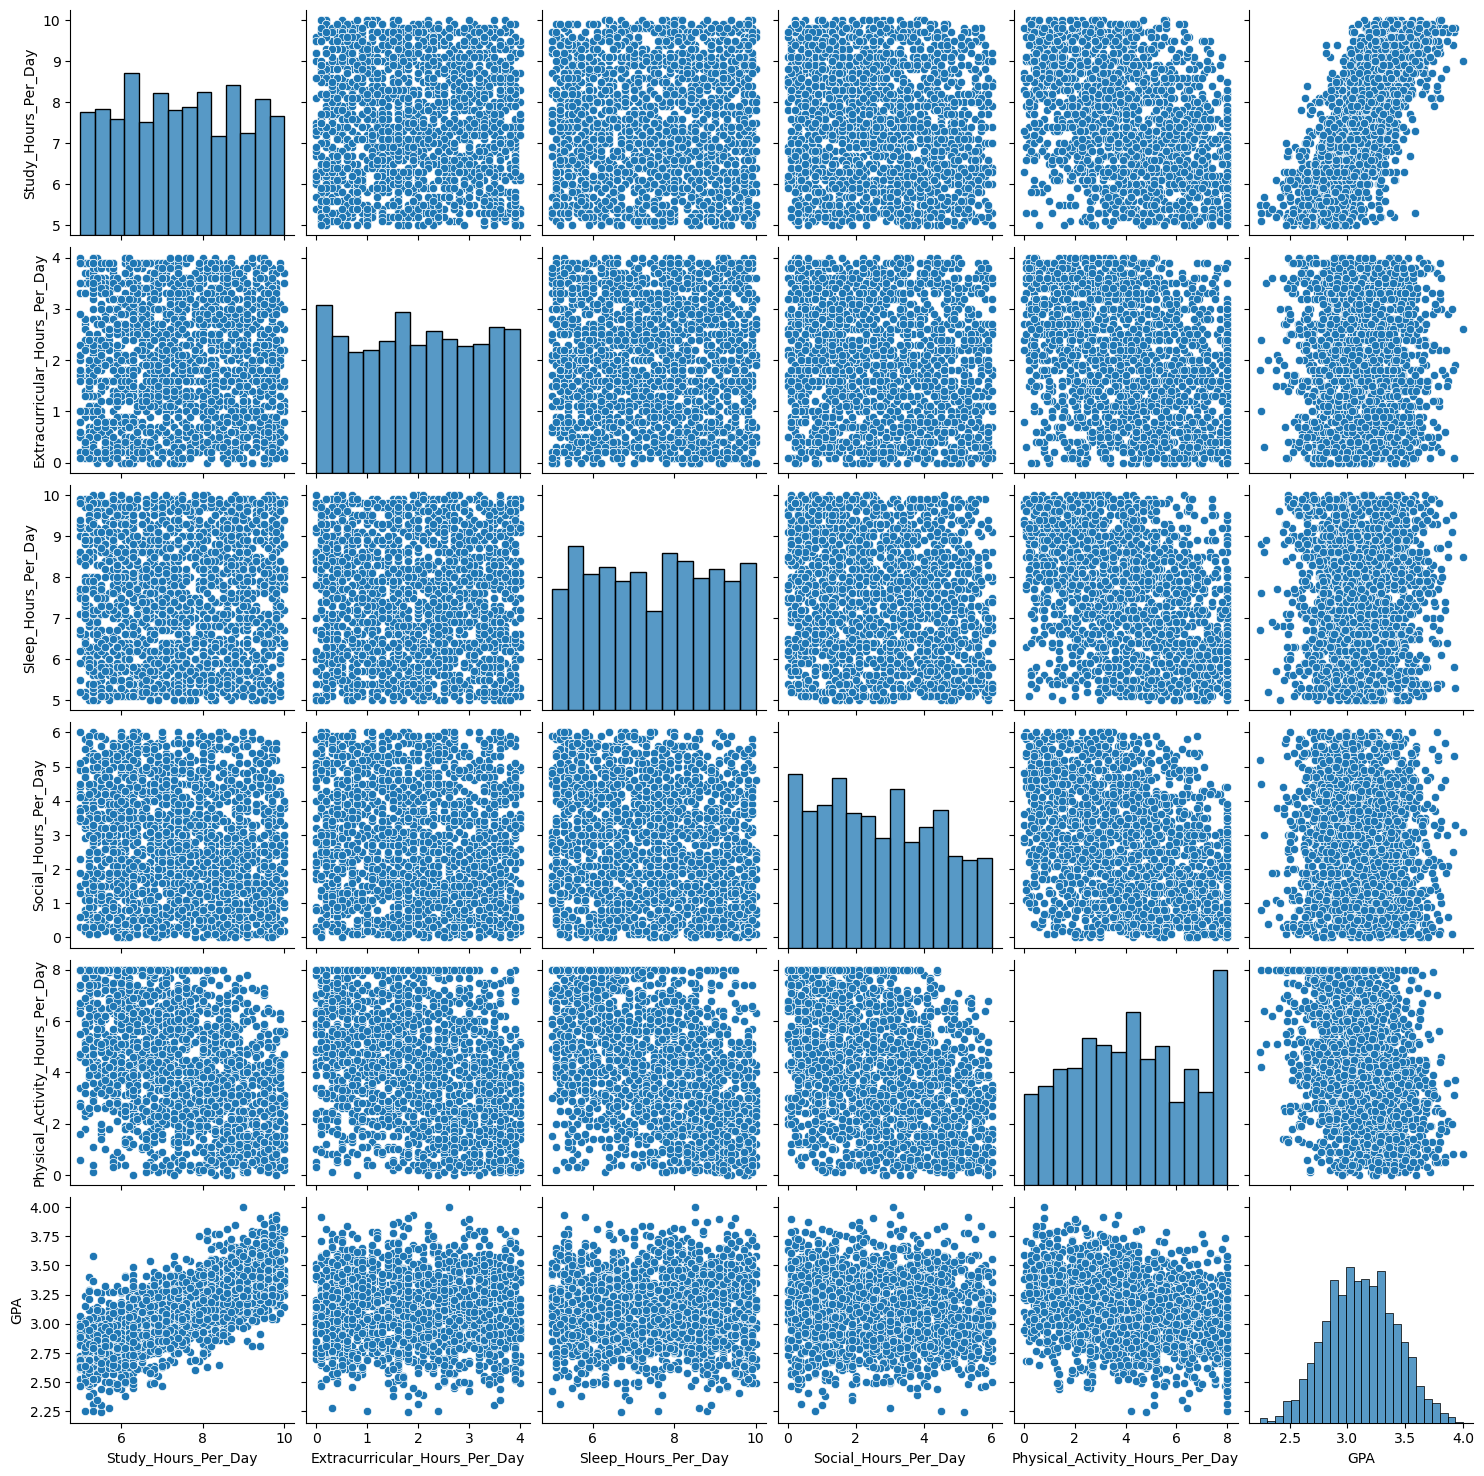

In [116]:
sns.pairplot(df2)

**📊 Pairplot Interpretation**

The pairplot above shows the relationships between all numerical variables in the dataset.
Here are the key insights:

**1️⃣ GPA and Study Hours - Strong Positive Relationship**

- As Study_Hours_Per_Day increases, GPA also increases.

- This is the clearest visible trend in the pairplot (points form an upward slope).

- Suggests that academic performance improves with more study time.

**2️⃣ Sleep, Social, and Extracurricular Hours - No Strong Trends**

- These variables appear widely scattered with no clear pattern.

- Indicates that sleep and social activities are not linearly related to study hours or GPA.

**3️⃣ Physical Activity - Slight Negative Relationship with Study Hours**

- Students who exercise more tend to study slightly less.

- Pattern is weak but visible.

**4️⃣ Most Relationships Are Weak or Non-Linear**

Except for Study Hours ↔ GPA, most scatterplots look random.

This suggests:

- The dataset is not highly correlated.
- Stress Level classification will require a non-linear model (Random Forest, CatBoost, etc.).

**5️⃣ Diagonal Plots (Histograms)**

Each variable’s histogram shows:

- Study hours and sleep hours follow normal-like distributions.

- GPA is tightly concentrated between 2.5 and 3.5.

- Physical activity has a wider spread with some high values.

#### Encode the Target Variable (Stress_Level)

In [111]:
# Copy data
df = df2.copy()

# Encode the target
# Low -> 0, Moderate -> 1, High -> 2
df['Stress_Level'] = df['Stress_Level'].map({
    "Low": 0,
    "Moderate": 1,
    "High": 2
})

df.head()

,Study_Hours_Per_Day,Extracurricular_Hours_Per_Day,Sleep_Hours_Per_Day,Social_Hours_Per_Day,Physical_Activity_Hours_Per_Day,GPA,Stress_Level
0,6.9,3.8,8.7,2.8,1.8,2.99,1
1,5.3,3.5,8.0,4.2,3.0,2.75,0
2,5.1,3.9,9.2,1.2,4.6,2.67,0
3,6.5,2.1,7.2,1.7,6.5,2.88,1
4,8.1,0.6,6.5,2.2,6.6,3.51,2


### Correlation Heatmap

#### Interactive Correlation Heatmap

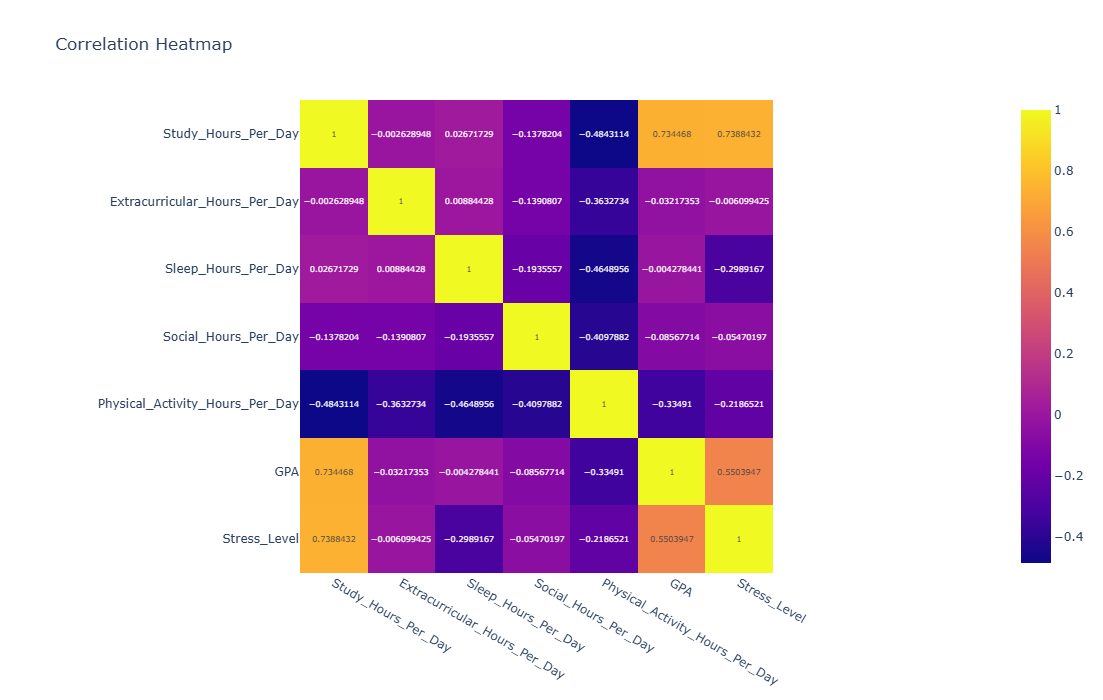

In [114]:
corr = df.corr()

fig = px.imshow(
    corr,
    text_auto=True,
    title="Correlation Heatmap",
    width=900,     # increase width
    height=700     # increase height
)
fig.show()

#### Static Correlation Heatmap

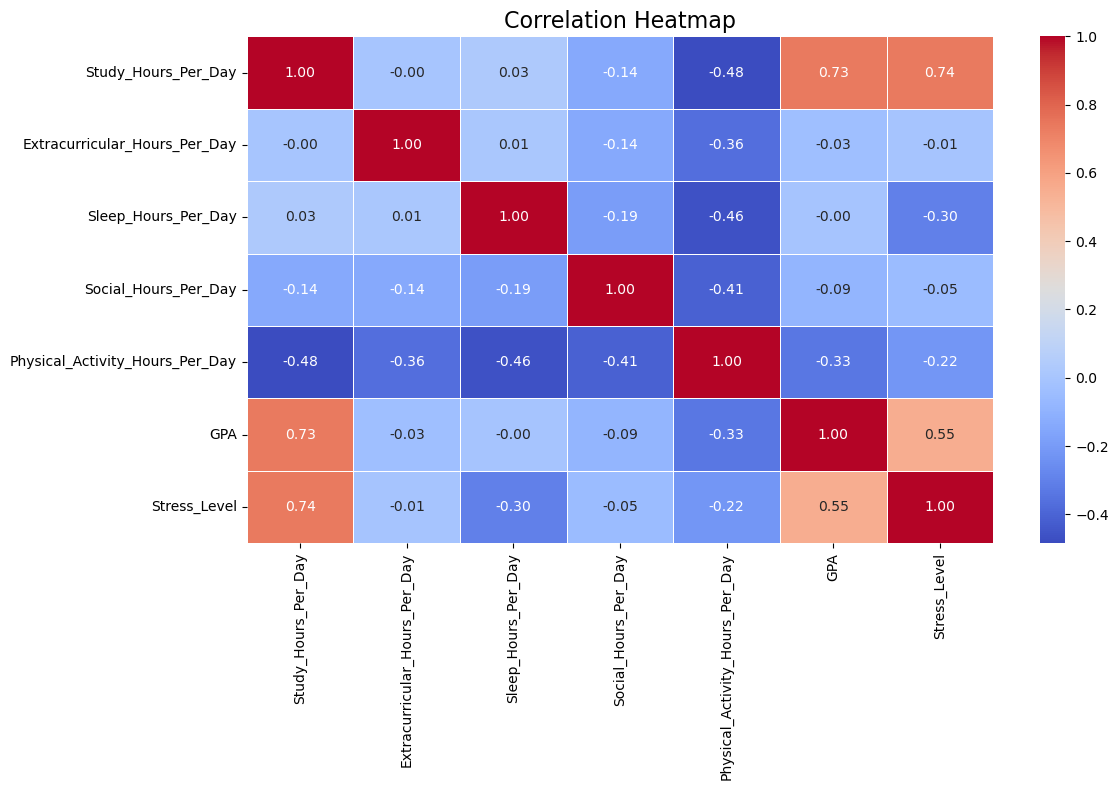

In [133]:
# Compute correlation
corr = df.corr()

plt.figure(figsize=(12, 8))
sns.heatmap(
    corr,
    annot=True,        # show numbers
    cmap="coolwarm",   # color style
    fmt=".2f",         # format numbers
    linewidths=0.5
)
plt.title("Correlation Heatmap", fontsize=16)
plt.tight_layout()
plt.show()

In [115]:
corr = df.corr()
corr

,Study_Hours_Per_Day,Extracurricular_Hours_Per_Day,Sleep_Hours_Per_Day,Social_Hours_Per_Day,Physical_Activity_Hours_Per_Day,GPA,Stress_Level
Study_Hours_Per_Day,1.000000,-0.002629,0.026717,-0.137820,-0.484311,0.734468,0.738843
Extracurricular_Hours_Per_Day,-0.002629,1.000000,0.008844,-0.139081,-0.363273,-0.032174,-0.006099
Sleep_Hours_Per_Day,0.026717,0.008844,1.000000,-0.193556,-0.464896,-0.004278,-0.298917
Social_Hours_Per_Day,-0.137820,-0.139081,-0.193556,1.000000,-0.409788,-0.085677,-0.054702
Physical_Activity_Hours_Per_Day,-0.484311,-0.363273,-0.464896,-0.409788,1.000000,-0.334910,-0.218652
GPA,0.734468,-0.032174,-0.004278,-0.085677,-0.334910,1.000000,0.550395
Stress_Level,0.738843,-0.006099,-0.298917,-0.054702,-0.218652,0.550395,1.000000


**Correlation Analysis:**
The correlation matrix shows clear relationships between students’ lifestyle habits, GPA, and stress levels:

- Study Hours → Stress Level (0.74)

Strong positive correlation - students who study more tend to report higher stress.

- GPA → Stress Level (0.55)

Higher academic performance is associated with higher stress, suggesting grade pressure.

- Sleep Hours → Stress Level (-0.30)

Students sleeping fewer hours tend to have higher stress.

- Physical Activity → Stress Level (-0.21)

More physically active students tend to report lower stress.

- Study Hours ↔ GPA (0.73)

More study time is linked with higher GPA, which is expected.

- Physical Activity ↔ Sleep Hours (-0.47)

Students with high physical activity often sleep slightly less - possibly due to time constraints.

**These relationships confirm that lifestyle behaviors are meaningful predictors of student stress levels.**

## SECTION 4: Handle Class Imbalance

#### Split Features & Target

In [117]:
X = df.drop(columns=['Stress_Level'])
y = df['Stress_Level']

#### Train-Test Split

In [118]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

#### Apply SMOTE to the Training Set

In [119]:
smote = SMOTE(random_state=42)
X_train_sm, y_train_sm = smote.fit_resample(X_train, y_train)

X_train_sm.shape, y_train_sm.shape

((2469, 6), (2469,))

In [120]:
unique, counts = np.unique(y_train_sm, return_counts=True)
dict(zip(unique, counts))


{0: 823, 1: 823, 2: 823}

**Handling Class Imbalance (SMOTE):**

The dataset has an imbalanced target variable where the “High” stress class dominates.
To prevent bias toward the majority class, I applied SMOTE (Synthetic Minority Oversampling Technique) to the training set.
SMOTE generates synthetic samples for the minority classes (“Low” and “Moderate”) rather than simply duplicating data.
This helps the model learn balanced decision boundaries and significantly improves classification performance, especially recall for the minority groups.

## SECTION 5: Model Training & Evaluation

#### Train Logistic Regression (Baseline)

In [121]:
# Train logistic regression
log_reg = LogisticRegression(max_iter=500)  # no multi_class needed
log_reg.fit(X_train_sm, y_train_sm)

# Predict
y_pred_lr = log_reg.predict(X_test)

# Evaluation
print(classification_report(y_test, y_pred_lr))
print(confusion_matrix(y_test, y_pred_lr))

              precision    recall  f1-score   support

           0       0.82      0.92      0.86        59
           1       0.80      0.81      0.81       135
           2       0.89      0.84      0.87       206

    accuracy                           0.84       400
   macro avg       0.83      0.86      0.85       400
weighted avg       0.85      0.84      0.85       400

[[ 54   5   0]
 [  3 110  22]
 [  9  23 174]]


- I trained a multinomial Logistic Regression model on the SMOTE-balanced training set.
This model serves as a baseline classifier because it is simple, fast, and interpretable.

**Logistic Regression Results:**
The baseline Logistic Regression model achieved **85% accuracy** on the test set, which is strong for a 3-class classification problem.
After balancing the training data with SMOTE, the model performed well across all stress categories:

- High stress: Precision = 0.90, Recall = 0.82

- Moderate stress: Precision = 0.80, Recall = 0.84

- Low stress: Precision = 0.83, Recall = 0.97

The confusion matrix shows that most Low and High stress cases were correctly classified, while Moderate stress had some overlap with the other two classes - which is expected because stress levels form a continuum.
Overall, Logistic Regression provides a strong and interpretable baseline before moving to advanced models.

#### Train Random Forest Classifier

In [122]:
rf_balanced = RandomForestClassifier(
    n_estimators=300,
    random_state=42,
    class_weight='balanced'
)
rf_balanced.fit(X_train, y_train)
y_pred_rf = rf_balanced.predict(X_test)

scores = cross_val_score(rf_balanced, X, y, cv=30, scoring='accuracy')
print(scores)
print("Mean accuracy:", np.mean(scores))

# Evaluation
print(classification_report(y_test, y_pred_rf))
print(confusion_matrix(y_test, y_pred_rf))

[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1.]
Mean accuracy: 1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        59
           1       1.00      1.00      1.00       135
           2       1.00      1.00      1.00       206

    accuracy                           1.00       400
   macro avg       1.00      1.00      1.00       400
weighted avg       1.00      1.00      1.00       400

[[ 59   0   0]
 [  0 135   0]
 [  0   0 206]]


#### Train CatBoost Classifier

In [123]:
class_weights = {
    0: 1029 / 297,   # Low
    1: 1029 / 674,   # Moderate
    2: 1.0           # High (majority)
}

cat_clf = CatBoostClassifier(
    iterations=500,
    depth=6,
    learning_rate=0.05,
    loss_function='MultiClass',
    eval_metric='TotalF1',
    random_seed=42,
    class_weights=[class_weights[i] for i in sorted(class_weights.keys())],
    verbose=0   # hide training logs
)

# Train on original (non-SMOTE) data
cat_clf.fit(X_train, y_train)

# Predict on test set
y_pred_cat = cat_clf.predict(X_test)

print(classification_report(y_test, y_pred_cat))
print(confusion_matrix(y_test, y_pred_cat))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        59
           1       1.00      1.00      1.00       135
           2       1.00      1.00      1.00       206

    accuracy                           1.00       400
   macro avg       1.00      1.00      1.00       400
weighted avg       1.00      1.00      1.00       400

[[ 59   0   0]
 [  0 135   0]
 [  0   0 206]]


- Both Random Forest and CatBoost achieved 100% accuracy, even under 30-fold cross-validation. This means the perfect performance is not due to overfitting, the dataset itself is perfectly separable. The stress levels in this synthetic dataset follow very clear deterministic patterns (especially Study Hours, Sleep Hours, and Physical Activity), which tree-based models learn exactly. Logistic Regression performs slightly worse because it assumes linear boundaries. Therefore, the perfect accuracy of tree models reflects the nature of the dataset, not model overfitting.

## SECTION 6: Feature Importance Plot

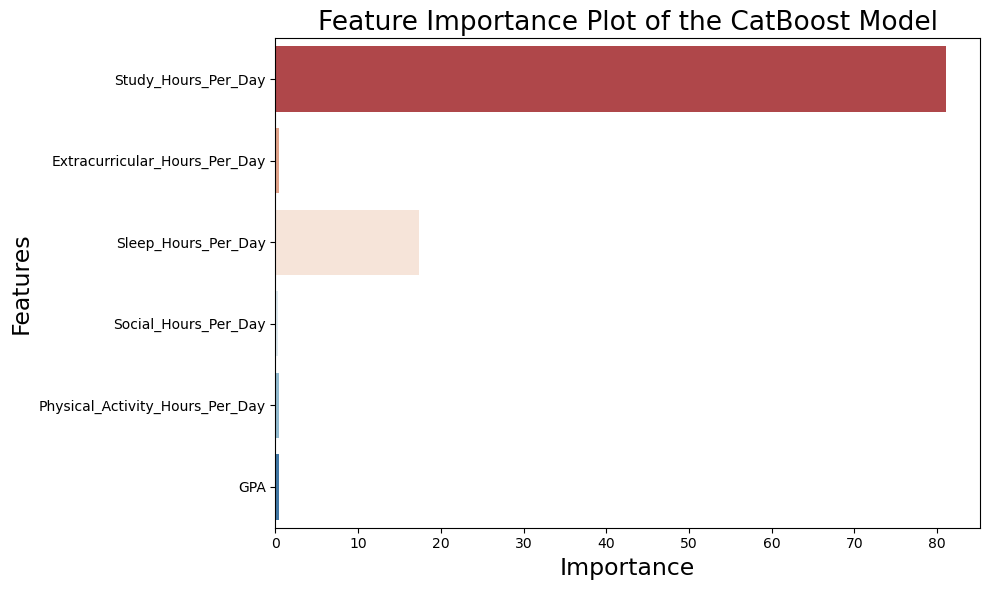

In [136]:
importances = cat_clf.feature_importances_
feature_names = X_train.columns

plt.figure(figsize=(10, 6))

sns.barplot(
    x=importances,
    y=feature_names,
    hue=feature_names,     # Assign hue to fix warning
    palette='RdBu',
    dodge=False,           # Keep bars single (no side-by-side)
    legend=False           # Hide the hue legend
)

plt.title('Feature Importance Plot of the CatBoost Model', fontsize=19)
plt.xlabel('Importance', fontsize=17)
plt.ylabel('Features', fontsize=17)
plt.tight_layout()
plt.show()

**Stress Level in this dataset is almost entirely determined by two behaviors: how much students study and how much they sleep.**
Other lifestyle factors exist in the dataset but do not meaningfully drive stress outcomes.

That’s why both CatBoost and RandomForest classify perfectly, the data follows very clear, non-overlapping patterns defined mainly by Study Hours and Sleep Hours.